In [2]:
import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
import keras
from keras.applications.resnet50 import ResNet50
from keras.models import Model
#Saving image to folders
import cv2
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Flatten

### Data Preprocessing

In [5]:
dat=pd.read_csv('/Users/priyanka99/CodeLabs/final_cleaned_dat.csv',dtype={'temperature':float})


#Retrieving and Storing images into separate folders
dirnamepos = 'covidpos'
dirnameneg = 'covidneg'
img_nid = 0
img_pid = 0

for ind in dat.index:
    
    if(dat['label'][ind] == 0 and cv2.imread(dat['file_path'][ind]) is not None):
        path = dat['file_path'][ind]
        img = cv2.imread(path)
        image_name = 'covidneg.'+str(img_nid)+'.png'
        cv2.imwrite(os.path.join(dirnameneg,image_name),img)
        img_nid = img_nid + 1
        
    elif(dat['label'][ind] == 1 and cv2.imread(dat['file_path'][ind])is not None):
        path = dat['file_path'][ind]
        img = cv2.imread(path)
        img_name = 'covidpos.'+ str(img_pid)+'.png'
        cv2.imwrite(os.path.join(dirnamepos,img_name),img)
        img_pid = img_pid + 1
        

In [7]:
covidneg_files = glob.glob('/Users/priyanka99/CodeLabs/covidneg/*')
covidpos_files = glob.glob('/Users/priyanka99/CodeLabs/covidpos/*')

#Undersampling data
covidpos_sub_files = np.random.choice(covidpos_files, size=291, replace=False)
covidpos_files = list(set(covidpos_files) - set(covidpos_sub_files))
len(covidneg_files), len(covidpos_files)

(221, 221)

### Spliting into Train, Test and Validation Directory

In [8]:
#Train, Test, validation split
covidneg_train = np.random.choice(covidneg_files, size=176, replace=False) 
covidpos_train = np.random.choice(covidpos_files, size=176, replace=False)

covidneg_files = list(set(covidneg_files) - set(covidneg_train))
covidpos_files = list(set(covidpos_files) - set(covidpos_train))

# covidneg_val = np.random.choice(covidneg_files, size=44, replace=False)
# covidpos_val = np.random.choice(covidpos_files, size=44, replace=False)

# covidneg_files = list(set(covidneg_files) - set(covidneg_val))
# covidpos_files = list(set(covidpos_files) - set(covidpos_val))

covidneg_test = np.random.choice(covidneg_files, size=44, replace=False)
covidpos_test = np.random.choice(covidpos_files, size=44, replace=False)


train_dir = 'training_data'
#val_dir = 'validation_data'
test_dir = 'test_data'

train_files = np.concatenate([covidneg_train, covidpos_train])
#validate_files = np.concatenate([covidneg_val, covidpos_val])
test_files = np.concatenate([covidneg_test, covidpos_test])

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
#os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)

# for fn in validate_files:
#     shutil.copy(fn, val_dir)
    
for fn in test_files:
    shutil.copy(fn, test_dir)

In [9]:
IMG_DIM = (300, 300)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
#train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in train_files]
train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files]

 
    
# validation_files = glob.glob('validation_data/*')
# validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
# validation_imgs = np.array(validation_imgs)
# validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (352, 300, 300, 3) 	Validation dataset shape: (0,)


(300, 300, 3)


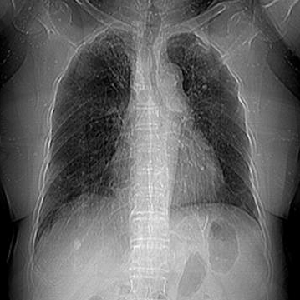

In [10]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[2].shape)
array_to_img(train_imgs[2]) #Testing


In [11]:
# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)


print(train_labels[90:100], train_labels_enc[90:100])

['covidneg', 'covidneg', 'covidpos', 'covidpos', 'covidneg', 'covidneg', 'covidneg', 'covidpos', 'covidpos', 'covidpos'] [0 0 1 1 0 0 0 1 1 1]


In [12]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)
# train_imgs_scaled, train_labels_enc = sm.fit_resample(train_imgs_scaled, train_labels_enc)


In [1]:
# from keras.utils.data_utils import Sequence
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.keras import balanced_batch_generator

# class BalancedDataGenerator(Sequence):
#     """ImageDataGenerator + RandomOversampling"""
#     def __init__(self, x, y, datagen, batch_size=32):
#         self.datagen = datagen
#         self.batch_size = batch_size
#         self._shape = x.shape        
#         datagen.fit(x)
#         self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)

#     def __len__(self):
#         return self._shape[0] // self.batch_size

#     def __getitem__(self, idx):
#         x_batch, y_batch = self.gen.__next__()
#         x_batch = x_batch.reshape(-1, *self._shape[1:])
#         return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()



Using TensorFlow backend.


In [11]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
 width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
 horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

#train_generator = BalancedDataGenerator(train_imgs_scaled, train_labels_enc, train_datagen, batch_size=32)
#val_generator = BalancedDataGenerator(validation_imgs_scaled, validation_labels_enc, val_datagen, batch_size=32)
train_generator = train_datagen.flow(train_imgs_scaled, train_labels_enc,batch_size=32)
val_generator = val_datagen.flow(validation_imgs_scaled, validation_labels_enc, batch_size=32)

### Using Resnet50 as pretrained model

In [13]:
from keras.applications.resnet50 import ResNet50, preprocess_input

IMG_HEIGHT = 300
IMG_WIDTH = 300

#What should be pooling?

resnet = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))


set_trainable = False
resnet.trainable = True
outputs = resnet.layers[-1].output
outputs = keras.layers.Flatten()(outputs)

resnet = Model(resnet.input, outputs=outputs)

for layer in resnet.layers:
    if layer.name in ['res5c_branch2b', 'res5c_branch2c', 'activation_97']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in resnet.layers]
#pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])
resnet.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [19]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
input_shape = (300, 300, 3)
model = Sequential()
model.add(resnet)

model.add(BatchNormalization(input_shape=(300,300,3)))
# model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.35))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.35))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 204800)            23587712  
_________________________________________________________________
batch_normalization_2 (Batch (None, 204800)            819200    
_________________________________________________________________
dense_8 (Dense)              (None, 512)               104858112 
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

### Training the Model

In [ ]:
history = model.fit(train_imgs_scaled,train_labels_enc, validation_split=0.20, epochs=30, batch_size=16, shuffle=True)
                    
                
#                               steps_per_epoch=8, 
#                               epochs=10, 
#                               validation_data=validation_imgs_scaled, 
#                               validation_steps=2, 
#                               verbose=1)

Epoch 1/30
18/18 [==============================] - 68s 4s/step - loss: 0.1545 - accuracy: 0.9751 - val_loss: 0.8093 - val_accuracy: 0.6056
Epoch 2/30
18/18 [==============================] - 57s 3s/step - loss: 0.1740 - accuracy: 0.9573 - val_loss: 0.8390 - val_accuracy: 0.6197
Epoch 3/30
18/18 [==============================] - 81s 5s/step - loss: 0.1455 - accuracy: 0.9573 - val_loss: 0.8553 - val_accuracy: 0.6620
Epoch 4/30
18/18 [==============================] - 61s 3s/step - loss: 0.1530 - accuracy: 0.9466 - val_loss: 0.8649 - val_accuracy: 0.6479
Epoch 5/30
18/18 [==============================] - 77s 4s/step - loss: 0.1242 - accuracy: 0.9680 - val_loss: 0.8827 - val_accuracy: 0.6197
Epoch 6/30
18/18 [==============================] - 108s 6s/step - loss: 0.1424 - accuracy: 0.9502 - val_loss: 0.9054 - val_accuracy: 0.6056
Epoch 7/30
18/18 [==============================] - 75s 4s/step - loss: 0.1360 - accuracy: 0.9715 - val_loss: 0.9329 - val_accuracy: 0.6197
Epoch 8/30
18/18 [=

In [16]:
model.save_weights('chest_xrayimage_covidmodel_4.h5')